- A simple RBF kernel based GP is trained on ~20k-30k data points (we use tinygp to train the model)
- Train-test split of data is done randomly and by drill-hole.
- Prediction on grid is done by using 

# Load Libraries

In [1]:
# Configure JAX

import os

# os.environ["JAX_PLATFORM_NAME"] = "cpu"
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=31' # Use all CPU devices
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = (
    "platform"  # Useful for limiting memory but maybe slows things down
)

In [2]:
import sys

sys.path.append("../src/")

In [3]:
import sys

sys.path.append("../src/")

import jax
import jax.numpy as jnp
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tinygp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tinygp import GaussianProcess, kernels, transforms
from tqdm.notebook import tqdm

from geostax.utils.model import batch_predict, batch_sample

# Get JAX devices for simplicity

cpus = jax.devices("cpu")
gpus = jax.devices("gpu")

In [4]:
# Control variables

TRAIN_YEAR = 2019
BATCH_SIZE = 1000
NOISE = 5e-2
CPU_DEVICE = cpus[0]
GPU_DEVICE = gpus[1]

In [5]:
# Modify the default jax device

jax.default_backend = GPU_DEVICE

### Preprocessing

In [6]:
# Load the datasets

xyz_grid = np.load("../cache/xyz_grid.npy")
df_assay_coords = pd.read_parquet("../cache/df_assay_coords.parquet")

# Remove NAs

df_assay_coords_filt = df_assay_coords.dropna().reset_index(drop=True)

In [7]:
# Normalization function for x, y and z
# I want each axis to be scaled between -1 and +1

x_scaler = MinMaxScaler().fit(xyz_grid[:, 0].reshape(-1, 1))
y_scaler = MinMaxScaler().fit(xyz_grid[:, 1].reshape(-1, 1))
z_scaler = MinMaxScaler().fit(xyz_grid[:, 2].reshape(-1, 1))

In [8]:
# Normalize the grid

xyz_grid_norm = np.hstack(
    [
        x_scaler.transform(xyz_grid[:, 0].reshape(-1, 1)),
        y_scaler.transform(xyz_grid[:, 1].reshape(-1, 1)),
        z_scaler.transform(xyz_grid[:, 2].reshape(-1, 1)),
    ]
)

In [9]:
# Now normalize the x, y, z of the observation locations

df_assay_coords_filt.loc[:, "x_inf_norm"] = x_scaler.transform(
    df_assay_coords_filt["x_inf"].to_numpy().reshape(-1, 1)
)
df_assay_coords_filt.loc[:, "y_inf_norm"] = y_scaler.transform(
    df_assay_coords_filt["y_inf"].to_numpy().reshape(-1, 1)
)
df_assay_coords_filt.loc[:, "z_inf_norm"] = z_scaler.transform(
    df_assay_coords_filt["z_inf"].to_numpy().reshape(-1, 1)
)

In [10]:
# Load collars data for spatial stratification etc.

df_collars = pd.read_excel(
    "../data/filo/filo_del_sol_drillhole_data_june_10_2024.xlsx", sheet_name="Collars"
)
df_collars["season_start"] = df_collars["Season"].str.split("/").str[0]  # .astype(int)
df_collars["season_start"] = df_collars["season_start"].astype(float)
df_collars["season_end"] = df_collars["Season"].str.split("/").str[1]  # .astype(int)
df_collars["season_end"] = df_collars["season_end"].astype(float)

### Gaussian Process Fitting Process

In [11]:
# Need a train-test splitting procedure with the following:

# 0. Randomly stratify observations (ultra-naive)
# 1. Randomly stratify drillholes (naive)
# 2. Spatially stratify drillholes (level 1)
# 3. Temporally stratify drillholes (level 2)
# 4. Spatiotemporally stratify drillholes (level 3)

In [12]:
# Filter the dataframe

df_raw = df_assay_coords_filt.loc[
    :, ["HOLE-ID", "x_inf_norm", "y_inf_norm", "z_inf_norm", "Cu %"]
]

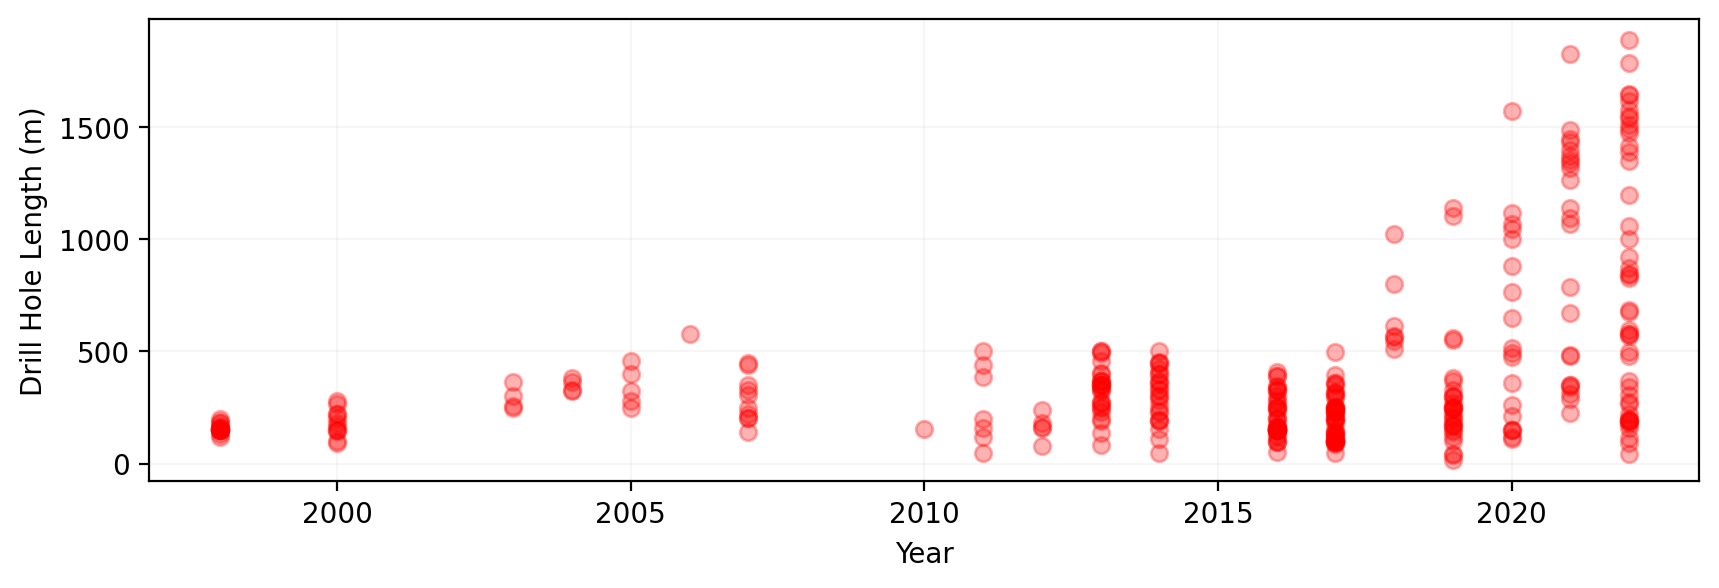

In [13]:
# Exploration of how many holes were drilled with time

plt.figure(figsize=(10, 3), dpi=200)
plt.plot(df_collars["season_start"], df_collars["Length (m)"], "ro", alpha=0.30)
plt.ylabel("Drill Hole Length (m)")
plt.xlabel("Year")
plt.grid(alpha=0.10)

In [14]:
# # Method 1: Use all the holes before 2015 to train the model, and predict on everything after 2015

# train_cond = df_collars["season_start"] <= float(TRAIN_YEAR)
# test_cond = df_collars["season_start"] > float(TRAIN_YEAR)
# train_holes = df_collars.loc[train_cond, "HOLE-ID"].tolist()
# test_holes = df_collars.loc[test_cond, "HOLE-ID"].tolist()
# # test_holes = [hole for hole in test_holes if hole not in train_holes]

In [15]:
# Method 2: Use all the holes before 2015 to train the model, and predict on everything after 2015

# train_cond = df_collars["season_start"] <= 2018
# test_cond = df_collars["season_start"] > 2018
# # train_index = np.sort(np.random.choice(np.arange(0, df_raw.shape[0]), 500, replace=False))
# # test_cond = df_collars["season_start"] == 2022
# train_holes = df_collars.loc[train_cond, "HOLE-ID"].to_numpy()
# test_holes = df_collars.loc[test_cond, "HOLE-ID"].to_numpy()

In [16]:
# Method 3: Random splitting data
# 0.34 for 20000

df_train, df_test = train_test_split(df_raw, train_size=0.38, random_state=50)
print(df_train.shape[0])
print(df_test.shape[0])

22403
36553


In [17]:
# # Get train and test data by filtering for respective holes

# df_train = df_raw.loc[df_raw["HOLE-ID"].isin(train_holes), :]
# df_test = df_raw.loc[df_raw["HOLE-ID"].isin(test_holes), :]

# print(df_train.shape[0])
# print(df_test.shape[0])

In [18]:
# # Quick analysis of number of samples per hole?

# df_assay_hole = df_assay_coords_filt.groupby("HOLE-ID")["Cu %"].count().reset_index()
# df_assay_hole = pd.merge(df_collars, df_assay_hole, on="HOLE-ID", how="left")
# df_assay_hole = df_assay_hole.groupby("season_start")["Cu %"].sum().reset_index()
# df_assay_hole

### Simple kriging model

In [19]:
# Get the variables of interest ready to go

FEATURES = ["x_inf_norm", "y_inf_norm", "z_inf_norm"]
TARGET = ["Cu %"]

# Training and test data split
# It is good to use numpy for now because it lets us store the data on CPU RAM for now
# When ready to move to GPU, we can use jax.device_put to move these to GPU

X_train = df_train[FEATURES].to_numpy()
y_train = df_train[TARGET].to_numpy()
X_test = df_test[FEATURES].to_numpy()
y_test = df_test[TARGET].to_numpy()

# Scale y train and test

target_scaler = StandardScaler().fit(np.log(y_train.reshape(-1, 1)))
y_train_sc = target_scaler.transform(np.log(y_train.reshape(-1, 1)))
y_test_sc = target_scaler.transform(np.log(y_test.reshape(-1, 1)))

# Move X_train and y_train to GPUs

X_train = jax.device_put(jnp.array(X_train), device=GPU_DEVICE)
y_train_sc = jax.device_put(jnp.array(y_train_sc), device=GPU_DEVICE)

2024-10-14 22:09:11.761573: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [20]:
# GP kernel definition


def build_gp(params):

    kernel = jnp.exp(params["log_amp"]) * transforms.Linear(
        -1 * jnp.exp(params["log_scale"]), kernels.ExpSquared()
    )

    # noise = tinygp.noise.Diagonal(jnp.exp(params["log_noise"]))

    return GaussianProcess(kernel, X_train, diag=jnp.exp(params["log_noise"]))

def loss(params):
    return -build_gp(params).log_probability(y_train_sc.flatten())

loss = jax.jit(loss, device=GPU_DEVICE)

def train_gp(init_params):

    solver = jaxopt.ScipyMinimize(fun=loss, maxiter=10000)
    print("Initial Marginal Likelihood: ", loss(init_params))
    soln = solver.run(init_params)
    print("Final Marginal Likelihood: ", loss(soln.params))
    return build_gp(soln.params)

In [21]:
# # Sample from GP prior

# params = {
#     "log_amp": np.float64(0.),
#     "log_scale": np.ones(3)*1,
# }
# gp_prior = build_gp(params)
# samples = gp_prior.sample(jax.random.PRNGKey(42), shape=(10, ))

# # Visualize samples from GP prior

# test_sample = samples[0, :]
# plt.figure(figsize=(10, 6))
# plt.subplot(3, 1, 1)
# plt.plot(X_train[:, 0], test_sample, "or", markersize=1)
# plt.subplot(3, 1, 2)
# plt.plot(X_train[:, 1], test_sample, "ob", markersize=1)
# plt.subplot(3, 1, 3)
# plt.plot(X_train[:, 2], test_sample, "ok", markersize=1)

In [ ]:
%%time

init_params = {
    "log_amp": jax.device_put(0., GPU_DEVICE),
    "log_scale": jax.device_put(jnp.zeros(3), GPU_DEVICE),
    "log_noise": jax.device_put(jnp.log(NOISE), GPU_DEVICE)
    # "log_noise": jnp.broadcast_to(-3., shape=y_train_sc.flatten().shape),
}
gp_model = train_gp(init_params)

Initial Marginal Likelihood:  90243.625


In [ ]:
# Print final hyperparameter values

print(gp_model.kernel.kernel1.value)
print(gp_model.kernel.kernel2.scale)
print(gp_model.noise.diag)

In [ ]:
%%time

# Prediction on the training data

# # Full-batch approach
# cond_gp = uncorr_gp.condition(y_train_sc.flatten(), X_train).gp
# y_train_mean = cond_gp.mean
# y_train_std = np.sqrt(cond_gp.variance)

y_train_mean, y_train_std = batch_predict(
    X_train,
    gp_model,
    y_train_sc,
    batch_size=BATCH_SIZE,
    cpu_device=CPU_DEVICE,
    gpu_device=GPU_DEVICE,
)

In [ ]:
# Prediction on the test data

y_test_mean, y_test_std = batch_predict(
    X_test,
    gp_model,
    y_train_sc,
    batch_size=BATCH_SIZE,
    cpu_device=CPU_DEVICE,
    gpu_device=GPU_DEVICE,
)

In [ ]:
# Rescale predictions for both train, test and std

y_train_mean_orig = np.exp(target_scaler.inverse_transform(y_train_mean.reshape(-1, 1)))
y_train_std_orig = np.exp(target_scaler.inverse_transform(y_train_std.reshape(-1, 1)))
y_test_mean_orig = np.exp(target_scaler.inverse_transform(y_test_mean.reshape(-1, 1)))
y_test_std_orig = np.exp(target_scaler.inverse_transform(y_test_std.reshape(-1, 1)))

# Plot Results (for quick feedback)

In [ ]:
y_max = np.max([y_train_mean_orig.max(), y_train.max()])
plt.figure(figsize=(3, 3), dpi=300)
# plt.vlines(
#     y_train,
#     y_train_mean_orig - 1.96 * y_train_std_orig,
#     y_train_mean_orig + 1.96 * y_train_std_orig,
#     colors="grey",
#     alpha=0.01,
#     linewidth=0.9
# )
plt.scatter(y_train, y_train_mean_orig, 
            s=8.0, c="b", alpha=0.50, ec="k", linewidths=0.20)
plt.plot([0, y_max], [0, y_max], "k-", alpha=1.0, linewidth=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(alpha=0.10)
plt.title("Cu %: Predicted from GP vs. Actual (Training)")

In [ ]:
y_max = np.max([y_test_mean_orig.max(), y_test.max()])
plt.figure(figsize=(3, 3), dpi=300)
# plt.vlines(
#     y_test,
#     y_test_mean_orig - 1.96 * y_test_std_orig,
#     y_test_mean_orig + 1.96 * y_test_std_orig,
#     colors="grey",
#     alpha=0.1,
# )
plt.scatter(y_test, y_test_mean_orig, 
            s=8.0, c="r", alpha=0.50, ec="k", linewidths=0.20)
plt.plot([0, y_max], [0, y_max], "k-", alpha=1.0, linewidth=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(alpha=0.10)
plt.title("Cu %: Predicted from GP vs. Actual (Test)")

# Save Results to disk

In [ ]:
# Combine train and test dataframes and save to disk

df_train["pred_sc"] = y_train_mean_orig
df_train["pred_sc_sd"] = y_train_std_orig
df_train["label"] = "train"
df_test["pred_sc"] = y_test_mean_orig
df_test["pred_sc_sd"] = y_test_std_orig
df_test["label"] = "test"

df_preds = pd.concat([df_train, df_test]).reset_index(drop=True)
df_preds["preds"] = np.exp(
    target_scaler.inverse_transform(df_preds["pred_sc"].to_numpy().reshape((1, -1)))
).flatten()
df_preds["preds_sd"] = np.exp(
    target_scaler.inverse_transform(df_preds["pred_sc_sd"].to_numpy().reshape((1, -1)))
).flatten()

df_preds.to_csv("../cache/df_preds.csv", index=False)

# Predict on all of normalized grid for paraview

In [ ]:
# Make xyz_grid_norm a jax.numpy array and store on CPU

xyz_grid_norm = jnp.array(xyz_grid_norm, device=cpus[0])
print(xyz_grid_norm.device)

In [ ]:
# Predict on the grid

y_grid_mean, y_grid_std = batch_predict(
    xyz_grid_norm,
    gp_model,
    y_train_sc,
    batch_size=BATCH_SIZE,
    cpu_device=CPU_DEVICE,
    gpu_device=GPU_DEVICE,
)

In [ ]:
# Re-scale to original units

y_grid_mean_orig = np.exp(target_scaler.inverse_transform(y_grid_mean.reshape(-1, 1)))
y_grid_std_orig = np.exp(target_scaler.inverse_transform(y_grid_std.reshape(-1, 1)))

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.hist(y_grid_mean_orig, bins=30, log=True, ec="k", fc="brown", alpha=0.9)
plt.xlabel("Mean Cu (%)")
plt.title("Grid: Mean Copper composition (%)")

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.hist(y_grid_std_orig, bins=30, log=True, ec="k", fc="grey", alpha=0.8)
plt.xlabel("Standard Deviation")
plt.title("Grid: Standard Deviation of Copper composition (%)")

In [ ]:
plt.figure(figsize=(6, 3), dpi=200)
plt.scatter(y_grid_mean_orig, y_grid_std_orig, 
            fc="green", s=2.0, alpha=0.50, ec="k", linewidths=0.05)
plt.xlabel("Mean Cu Composition (%)")
plt.ylabel("Standard Deviation")
plt.title("Grid: Standard Deviation of Copper composition (%)")
plt.grid(alpha=0.10)

In [ ]:
# Draw some samples to see how they look

y_samples = batch_sample(
    xyz_grid_norm,
    gp_model,
    y_train_sc,
    batch_size=BATCH_SIZE,
    cpu_device=CPU_DEVICE,
    gpu_device=GPU_DEVICE,
    key=jax.random.PRNGKey(32),
    n_samples=1,
)

print(y_samples.shape)

In [ ]:
y_samples_orig = np.exp(target_scaler.inverse_transform(y_samples))
plt.figure(figsize=(6, 3), dpi=200)
plt.hist(y_samples_orig, bins=30, log=True, ec="k", fc="brown", alpha=0.9)
plt.xlabel("Mean Cu (%)")
plt.title("Grid: Mean Copper composition (%)")

In [ ]:
# Preprocessing for compatibility with Paraview

df_grid = pd.DataFrame(xyz_grid, columns=["x_norm", "y_norm", "z_norm"])
df_grid["cu_pred_perc"] = y_grid_mean_orig
df_grid["std"] = y_grid_std_orig
df_grid["cu_pred_sample"] = y_samples_orig
df_grid = df_grid.sort_values(["z_norm", "y_norm", "x_norm"]).reset_index(drop=True)
df_grid.to_csv("../cache/df_preds_grid.csv", index=False)